## plotNWT_hillslope_simple _KJ_ additions of observations
#### Plots results from hillslope simulation
- Obs here are flux tower data, included in met forcing data
- Created by Will Wieder, Sept 28, 2021

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
from scipy import signal,stats
import cftime
import nc_time_axis
import dask
#import cf_units as cf

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from distributed import wait

%matplotlib inline

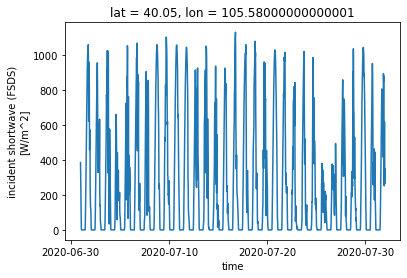

In [2]:
din = ['/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/moist_meadow2020/']
fin = [din[0] + '2020-07.nc']  
ds = utils.time_set_mid(xr.open_mfdataset(fin, decode_times=True, combine='by_coords'), 'time').load()
ds = ds.isel(lat=0,lon=0)
ds.FSDS.plot() ;

In [4]:
Var = ['FSDS','TBOT','Rnet']
ds[Var[0]]

<xarray.DataArray 'FSDS' (time: 1488)>
array([385.3 , 283.27, 181.9 , ..., 618.53, 262.49, 350.06])
Coordinates:
    lat      float64 40.05
    lon      float64 105.6
  * time     (time) object 2020-07-01 00:00:00 ... 2020-07-31 23:30:00
Attributes:
    units:      W/m^2
    long_name:  incident shortwave (FSDS)
    mode:       time-dependent

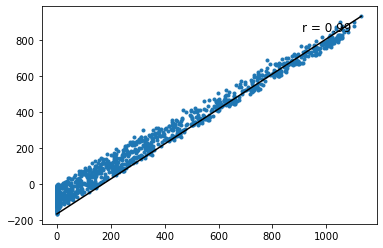

In [5]:
Var = ['FSDS','TBOT','Rnet']
fig, ax = plt.subplots()
x, y = ds[Var[0]].values,  ds[Var[2]].values

ax.plot(x, y,'.')
line = mlines.Line2D([x.min(), x.max()], [y.min(), y.max()], color='k')
ax.add_line(line)
#ax.text(0.15, 0.90,(Var[0]+', ', fontsize=14, 
#        ha='center', va='center', transform=plt.gca().transAxes);

# drop missing values from x,y
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
x = np.compress(bad, x)  
y = np.compress(bad, y) 

R, p = stats.pearsonr(x,y)
R = np.round(R, 2)
ax.text(0.85, 0.90,'r = '+str(R),fontsize=12, 
        ha='center', va='center', transform=plt.gca().transAxes);

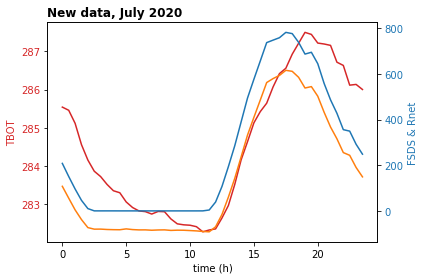

In [6]:
ds['HourMin'] = np.round(ds['time.hour'] + ds['time.minute']/60,1)
rollHour = -12 

diel = ds.groupby(ds['HourMin']).mean()#.roll(HourMin=rollHour, roll_coords=False)
dielSD = ds.groupby(ds['HourMin']).std()#.roll(HourMin=rollHour, roll_coords=False)
x = diel.HourMin

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (h)')
ax1.set_ylabel('TBOT', color=color)
ax1.plot(x, diel[Var[1]], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('FSDS & Rnet', color=color)  # we already handled the x-label with ax1
ax2.plot(x, diel[Var[0]], color=color)
ax2.tick_params(axis='y', labelcolor=color)

#ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
#ax3.set_ylabel(Var[2], color=color)  # we already handled the x-label with ax1
ax2.plot(x, diel[Var[2]], color=color)
#ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title('New data, July 2020',  loc='left', fontsize='large', fontweight='bold')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
